# Wczytanie danych:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

#Zbiór danych users
users = pd.read_csv('ausers.csv', delimiter=';')
#print(users.head(50))

In [2]:
depression = pd.read_csv('adepression.csv', delimiter=';')

duplicates = depression.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

# Usuwanie wierszy:

Do usuwania numery wierszy -2 w stosunku do csv
Powtarzające się ID w aanixiety: 
- ID83 - ponad rok różnicy, zostawione oba
- ID76 - -//-
- ID86 - mniej niż godzina różnicy, wywalić wiersz nr 41 (albo 40 bez nagłówka)
- ID82 - ponad rok różnicy, zostawione oba
- ID215 - ponad dzień różnicy, zostawione oba
- ID162 - mniej niż godzina różnicy, wywalić wiersz nr 70 (albo 69 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz nr 93 (92 bez nagłówka)
- ID214 - 22h różnicy??? - zatwierdzone - oba zostawić!!!
- ID129 - kilka dni różnicy, zostawione oba

W adepression: 
Pierwsze dwa tak samo.
ID86 nie istnieje???
- ID82 - mniej niż godzina różnicy, wywalić wiersz nr 36 (albo 35 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz 70

In [3]:
do_usuniecia_depression = [34, 68]
depression = depression.drop(depression.index[do_usuniecia_depression])
depression = depression.reset_index(drop=True)

# Przygotowanie danych: 

In [4]:
# Przygotowanie atrybutów depression:
d_split = depression['attributes'].str.split('|', expand=True)
d_split.columns = [f'f_{i}' for i in range(d_split.shape[1])]
depression = pd.concat([d_split, depression['date'], depression['email'], depression['gender']], axis=1)
print(depression.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   1   1   0   3   2   1   2   0   2   1  2021-11-13 14:52  ID13      M
1   1   1   1   1   1   0   1   1   0   1  2021-11-13 14:52  ID48      M
2   1   1   0   1   1   1   1   1   1   1  2021-11-13 15:03   ID6      M
3   1   1   1   1   0   1   1   1   1   1  2021-11-13 15:04  ID34      M
4   2   0   0   1   2   2   1   1   2   2  2021-11-13 15:04   ID5      K


# Optymalizacja liczby skupień metodą łokcia

*** Eksperyment numer:1 Jakość= 564.3440860215053
*** Eksperyment numer:2 Jakość= 382.9952153110048
*** Eksperyment numer:3 Jakość= 316.83202371105597
*** Eksperyment numer:4 Jakość= 288.6246844319776
*** Eksperyment numer:5 Jakość= 260.2385918003565
*** Eksperyment numer:6 Jakość= 246.4229548229548
*** Eksperyment numer:7 Jakość= 229.3354700854701
*** Eksperyment numer:8 Jakość= 217.62803776683086
*** Eksperyment numer:9 Jakość= 209.02023809523808


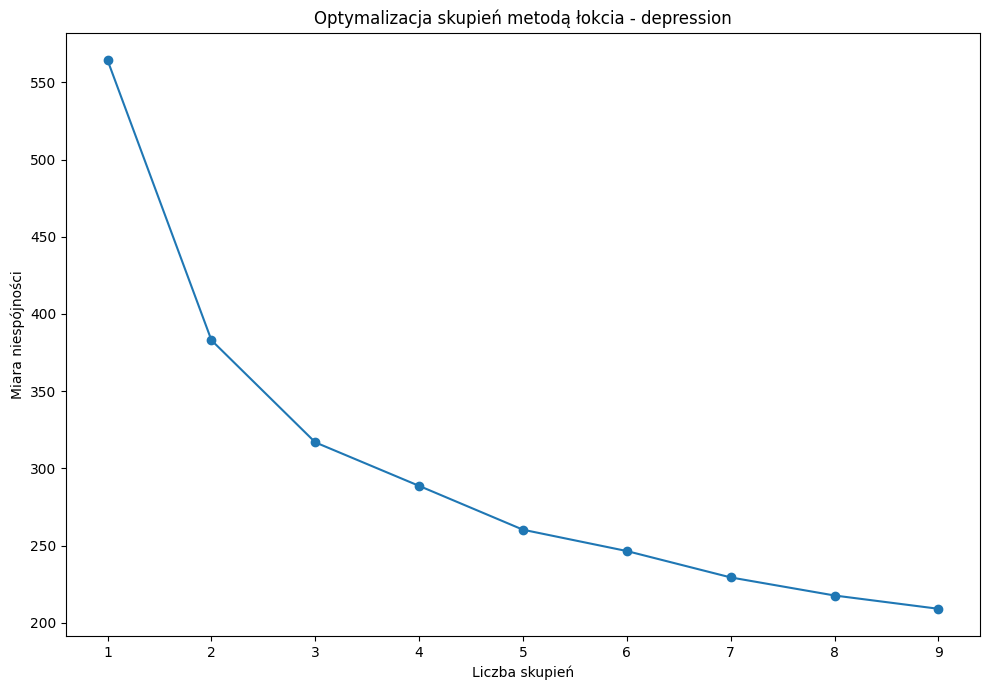

In [5]:
n = 10 #liczba eksperymentów

featuresD = depression.iloc[:,0:10] #cechy do grupowania
#print(features)

results = []
for k in range(1, n):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(featuresD)
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = kmeans.inertia_ #Powinna być jak najmniejsza
    
    results.append(inertia)
    
    print("*** Eksperyment numer:"+str(k)+" Jakość=",inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia 
#Widać, że w tym przypadku optymalne k=3

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,n), results , marker='o')
plt.title("Optymalizacja skupień metodą łokcia - depression")
plt.xlabel('Liczba skupień')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()

# Grupowanie metodą K-means

In [6]:
#Grupowanie - depression:
#Dla 2 klastrów:
kmeansD = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansD.fit(featuresD) #Grupowanie

inertiaD = kmeansD.inertia_
print("Miara jakości=",inertiaD);

centroidsD = kmeansD.cluster_centers_
print("Centroidy: \n",centroidsD)

clustersD = kmeansD.fit_predict(featuresD)

Miara jakości= 382.9952153110048
Centroidy: 
 [[0.47272727 0.58181818 0.54545455 0.92727273 0.58181818 0.54545455
  0.8        0.41818182 0.6        0.56363636]
 [1.10526316 1.15789474 1.05263158 2.36842105 1.86842105 1.07894737
  1.36842105 1.18421053 1.68421053 1.55263158]]


In [7]:
#Dla 3 klastrów:
kmeansD3 = KMeans(n_clusters=3, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansD3.fit(featuresD) #Grupowanie

inertiaD3 = kmeansD3.inertia_
print("Miara jakości=",inertiaD3);

centroidsD3 = kmeansD3.cluster_centers_
print("Centroidy: \n",centroidsD3)

clustersD3 = kmeansD3.fit_predict(featuresD)

Miara jakości= 316.83202371105597
Centroidy: 
 [[0.11111111 0.38888889 0.41666667 0.88888889 0.5        0.36111111
  0.61111111 0.19444444 0.41666667 0.36111111]
 [1.11538462 1.26923077 1.11538462 3.         1.96153846 1.07692308
  1.46153846 1.15384615 1.73076923 1.69230769]
 [1.12903226 0.93548387 0.83870968 1.         1.09677419 0.96774194
  1.16129032 1.         1.19354839 1.06451613]]


# Ocena jakości grupowania - miara Silhouette

Przyjmuje wartości od -1 do 1, gdzie 1 to idealne dopasowanie, a im bliżej 0, tym gorzej dopasowane są klastry. Wartości poniżej 0 oznaczają złe dopasowanie

In [12]:
from sklearn.metrics import silhouette_score
clustersD = kmeansD.fit_predict(featuresD)
silhouette_avg = silhouette_score(featuresD, clustersD)
print(f"Średnia wartość silhouette dla depression, liczba skupień 2: {silhouette_avg:.3f}")

silhouette_avg3 = silhouette_score(featuresD, clustersD3)
print(f"Średnia wartość silhouette dla depression, liczba skupień 3: {silhouette_avg3:.3f}")

Średnia wartość silhouette dla depression, liczba skupień 2: 0.263
Średnia wartość silhouette dla depression, liczba skupień 3: 0.207


*** Eksperyment numer: 2 Jakość dla depression =  0.26347757893717044
*** Eksperyment numer: 3 Jakość dla depression =  0.20690843465797493
*** Eksperyment numer: 4 Jakość dla depression =  0.21215393123648899
*** Eksperyment numer: 5 Jakość dla depression =  0.1878314277404958
*** Eksperyment numer: 6 Jakość dla depression =  0.16067349850489185
*** Eksperyment numer: 7 Jakość dla depression =  0.16214558003812538
*** Eksperyment numer: 8 Jakość dla depression =  0.1767959592960145
*** Eksperyment numer: 9 Jakość dla depression =  0.15929591562735268


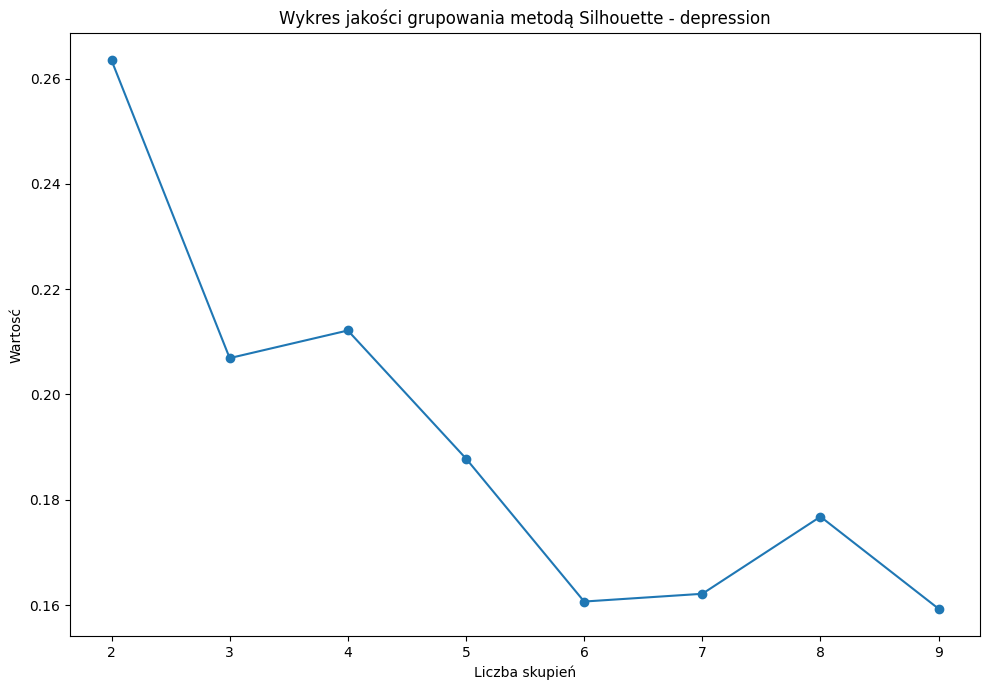

In [9]:
results_depression = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(featuresD) #Grupowanie depression
    clustersD = kmeans.predict(featuresD)
    #Obliczenie jakości grupowania
    silhouette_avgD = silhouette_score(featuresD, clustersD) #Powinna być jak najbliższa 1, ale broń Boże nie poniżej 0
    results_depression.append(silhouette_avgD)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość dla depression = ", silhouette_avgD)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_depression , marker='o')
plt.title("Wykres jakości grupowania metodą Silhouette - depression")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Indeks Davies - Bouldin

Indeks Davies-Bouldin (DBI) przyjmuje wartości w zakresie od 0 do nieskończoności. W praktyce wyniki zazwyczaj mieszczą się w zakresie od 0 do kilku jednostek, w zależności od charakterystyki danych i jakości klastrów.

Interpretacja wartości DBI:
- 0: Idealne klastry – maksymalna kompaktowość i doskonałe odseparowanie (rzadko osiągane w rzeczywistych danych).
- Niskie wartości (blisko 0): Wskazują na dobrze zdefiniowane klastry – mała rozbieżność w obrębie klastrów oraz duża separacja między nimi.
Wyższe wartości (np. >1): Wskazują na gorszą jakość klastrów – większe nakładanie się klastrów lub brak wyraźnych granic.

In [13]:
# Obliczenie indeksu Davies-Bouldin
from sklearn.metrics import davies_bouldin_score
clustersD = kmeansD.fit_predict(featuresD)

dbi = davies_bouldin_score(featuresD, clustersD)
print(f"Indeks Davies-Bouldin, liczba skupień 2: {dbi:.3f}")

dbi3 = davies_bouldin_score(featuresD, clustersD3)
print(f"Indeks Davies-Bouldin, liczba skupień 3: {dbi3:.3f}")

Indeks Davies-Bouldin, liczba skupień 2: 1.399
Indeks Davies-Bouldin, liczba skupień 3: 1.535


*** Eksperyment numer: 2 Jakość dla depression =  1.3986343171357156
*** Eksperyment numer: 3 Jakość dla depression =  1.5351983820465958
*** Eksperyment numer: 4 Jakość dla depression =  1.5815830676307396
*** Eksperyment numer: 5 Jakość dla depression =  1.696655220558179
*** Eksperyment numer: 6 Jakość dla depression =  1.7232894953423978
*** Eksperyment numer: 7 Jakość dla depression =  1.6511492245133732
*** Eksperyment numer: 8 Jakość dla depression =  1.5073037213889877
*** Eksperyment numer: 9 Jakość dla depression =  1.5723663039022542


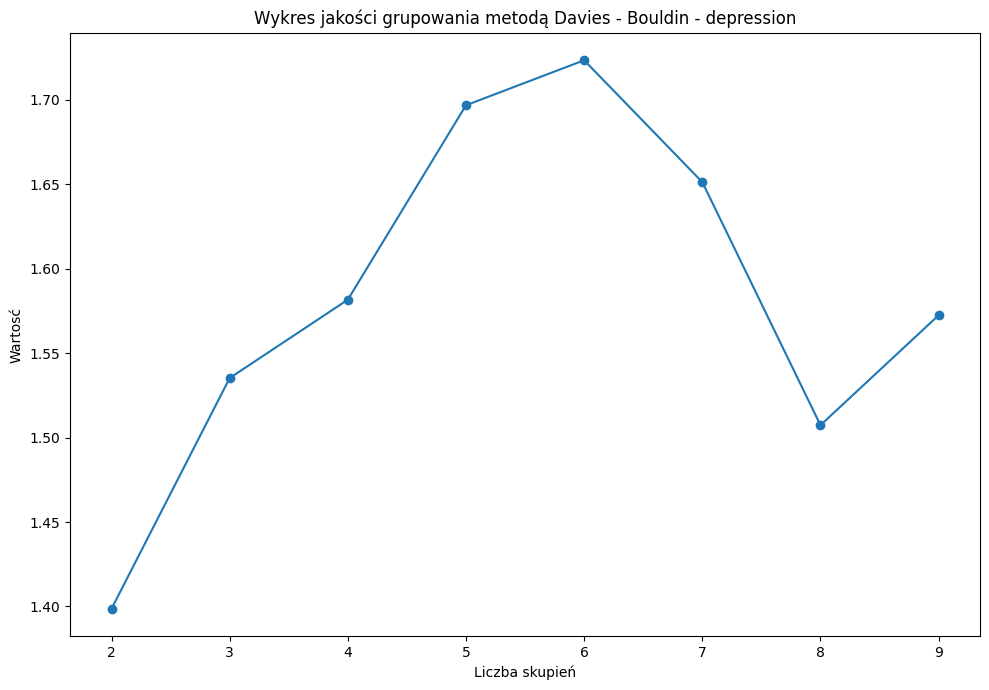

In [11]:
results_depression = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(featuresD) #Grupowanie depression
    clustersD = kmeans.predict(featuresD)
    #Obliczenie jakości grupowania
    dbiD = davies_bouldin_score(featuresD, clustersD)
    results_depression.append(dbiD)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość dla depression = ", dbiD)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_depression , marker='o')
plt.title("Wykres jakości grupowania metodą Davies - Bouldin - depression")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Miara Calinski-Harabasz

Interpretacja wartości:

Wysokie wartości miary Calinski-Harabasz oznaczają:
- Lepsze separowanie klastrów.
- Większą spójność wewnątrz klastrów.
  
Niskie wartości sugerują słabe grupowanie – klastry są rozproszone lub nakładają się.

In [14]:
from sklearn.metrics import calinski_harabasz_score
clustersD = kmeansD.fit_predict(featuresD)
ch_score = calinski_harabasz_score(featuresD, clustersD)
print("Calinski-Harabasz score, liczba skupień 2:", ch_score)

ch_score3 = calinski_harabasz_score(featuresD, clustersD3)
print("Calinski-Harabasz score, liczba skupień 3:", ch_score3)

Calinski-Harabasz score, liczba skupień 2: 43.08865117611137
Calinski-Harabasz score, liczba skupień 3: 35.15440981473476


*** Eksperyment numer: 2 Jakość dla depression =  43.08865117611137
*** Eksperyment numer: 3 Jakość dla depression =  35.15440981473476
*** Eksperyment numer: 4 Jakość dla depression =  28.34018024683919
*** Eksperyment numer: 5 Jakość dla depression =  25.70841175623096
*** Eksperyment numer: 6 Jakość dla depression =  22.44850804110023
*** Eksperyment numer: 7 Jakość dla depression =  20.937843413233377
*** Eksperyment numer: 8 Jakość dla depression =  19.34550109578827
*** Eksperyment numer: 9 Jakość dla depression =  17.849469684011442


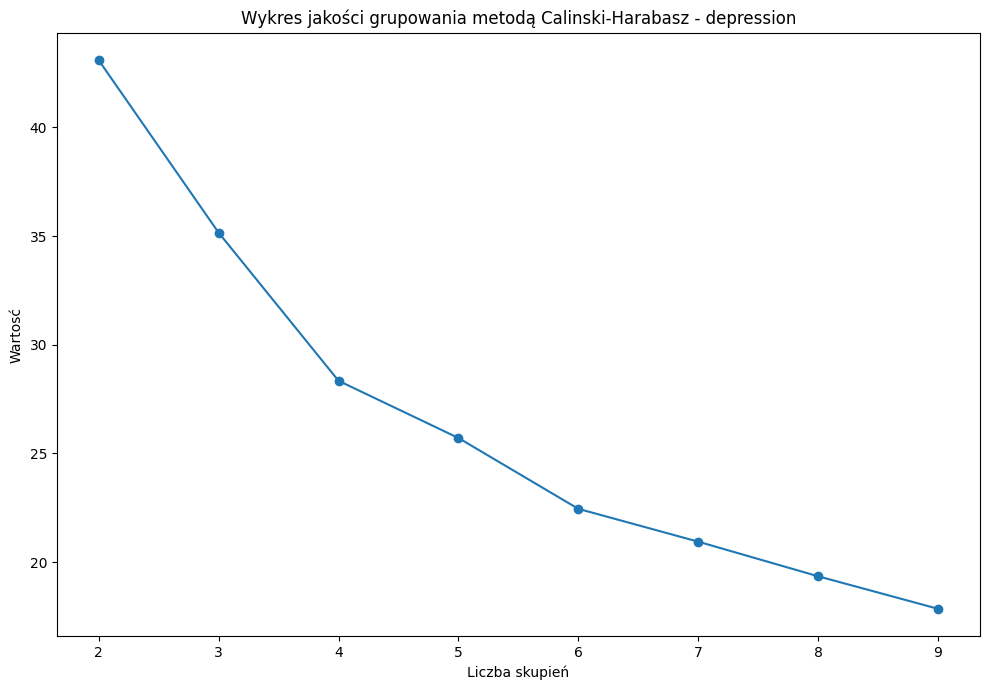

In [63]:
results_anxiety = []
results_depression = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)

    kmeans.fit(featuresD) #Grupowanie depression
    clustersD = kmeans.predict(featuresD)
    #Obliczenie jakości grupowania
    ch_scoreD = calinski_harabasz_score(featuresD, clustersD)
    results_depression.append(ch_scoreD)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość dla depression = ", ch_scoreD)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_depression , marker='o')
plt.title("Wykres jakości grupowania metodą Calinski-Harabasz - depression")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Wizualizacja skupień 
Metoda PCA

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


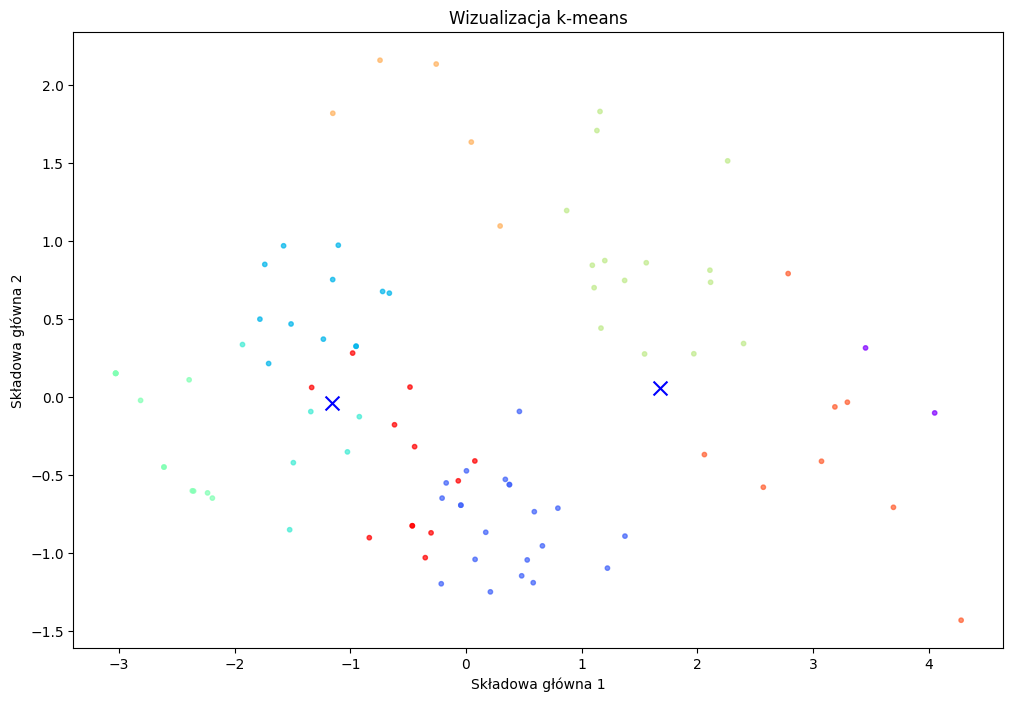

In [64]:
#Depression
clusters = kmeans.fit_predict(featuresD)

#Redukcja wymiarów za pomocą PCA - dane są sprowadzane do 2 wymiarów
pca = PCA(n_components=2)
features_pca = pca.fit_transform(featuresD)
centroids_pca = pca.transform(centroidsD)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja k-means')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='rainbow', s=10, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, color='blue', marker='x')
plt.xlabel('Składowa główna 1')
plt.ylabel('Składowa główna 2')
plt.show()

# Grupowanie metodą hierarchiczną

In [65]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
ac.fit(featuresD)

clustersHierarchy = ac.fit_predict(featuresD)

for i in range(0,len(clustersD)):
    print("Obiekt numer:"+str(i)," Skupienie:"+str(clustersHierarchy[i]))

Obiekt numer:0  Skupienie:1
Obiekt numer:1  Skupienie:0
Obiekt numer:2  Skupienie:1
Obiekt numer:3  Skupienie:0
Obiekt numer:4  Skupienie:1
Obiekt numer:5  Skupienie:0
Obiekt numer:6  Skupienie:0
Obiekt numer:7  Skupienie:0
Obiekt numer:8  Skupienie:0
Obiekt numer:9  Skupienie:0
Obiekt numer:10  Skupienie:1
Obiekt numer:11  Skupienie:1
Obiekt numer:12  Skupienie:0
Obiekt numer:13  Skupienie:0
Obiekt numer:14  Skupienie:0
Obiekt numer:15  Skupienie:0
Obiekt numer:16  Skupienie:1
Obiekt numer:17  Skupienie:0
Obiekt numer:18  Skupienie:0
Obiekt numer:19  Skupienie:0
Obiekt numer:20  Skupienie:0
Obiekt numer:21  Skupienie:1
Obiekt numer:22  Skupienie:0
Obiekt numer:23  Skupienie:0
Obiekt numer:24  Skupienie:1
Obiekt numer:25  Skupienie:0
Obiekt numer:26  Skupienie:0
Obiekt numer:27  Skupienie:1
Obiekt numer:28  Skupienie:1
Obiekt numer:29  Skupienie:1
Obiekt numer:30  Skupienie:0
Obiekt numer:31  Skupienie:0
Obiekt numer:32  Skupienie:1
Obiekt numer:33  Skupienie:0
Obiekt numer:34  Skupien

# Wizualizacje grupowania hierarchicznego

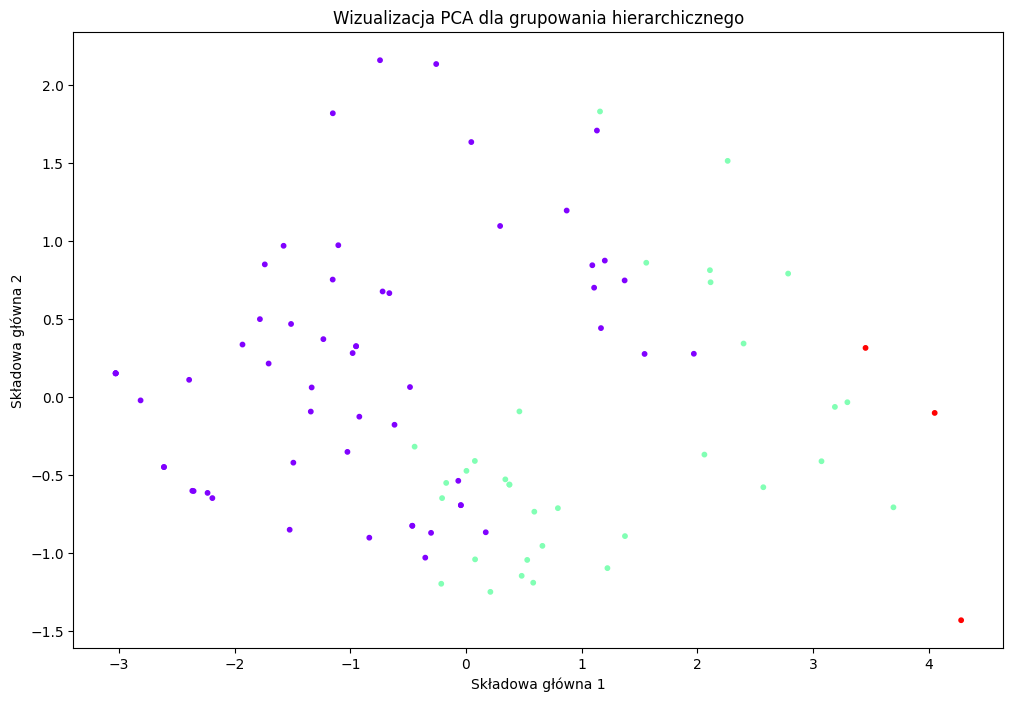

In [66]:
#Depression
# Redukcja wymiarów za pomocą PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(featuresD)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja PCA dla grupowania hierarchicznego')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersHierarchy, s=10, alpha=0.99, cmap='rainbow')
plt.xlabel("Składowa główna 1")
plt.ylabel("Składowa główna 2")
plt.show()

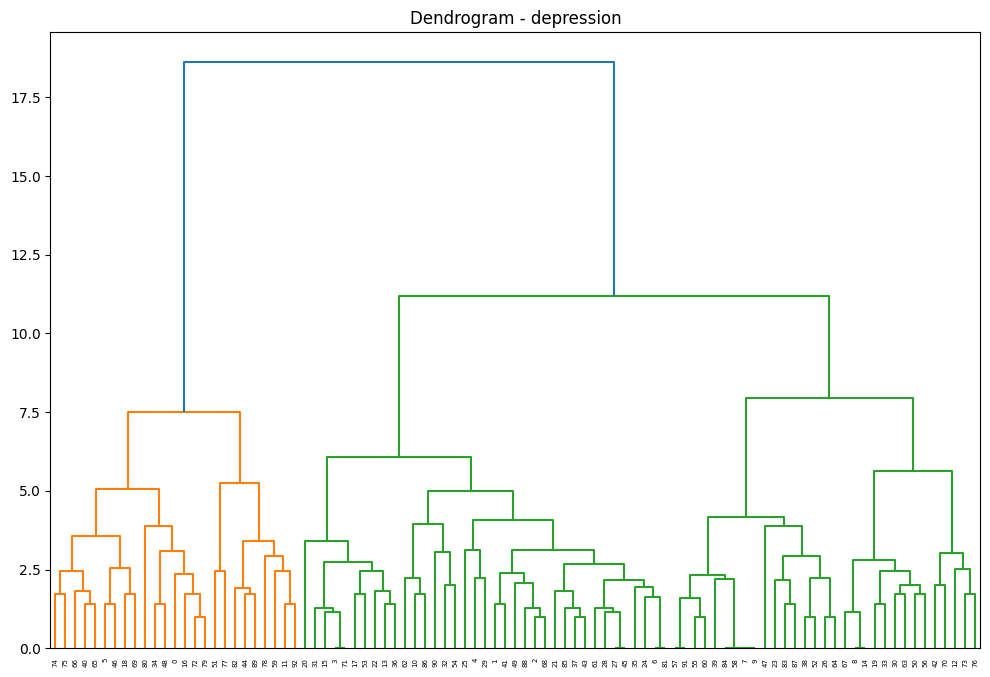

In [67]:
plt.figure(figsize=(12, 8))
plt.title("Dendrogram - depression")
dend = shc.dendrogram(shc.linkage(featuresD, method='ward'))
plt.show()

# Właściwe grupowanie

In [74]:
kmeansD = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansD.fit(featuresD) #Grupowanie

inertiaD = kmeansD.inertia_
print("Miara jakości=",inertiaD);

centroidsD = kmeansD.cluster_centers_
print("Centroidy: \n",centroidsD)

clustersD = kmeansD.fit_predict(featuresD)

Miara jakości= 382.9952153110048
Centroidy: 
 [[0.47272727 0.58181818 0.54545455 0.92727273 0.58181818 0.54545455
  0.8        0.41818182 0.6        0.56363636]
 [1.10526316 1.15789474 1.05263158 2.36842105 1.86842105 1.07894737
  1.36842105 1.18421053 1.68421053 1.55263158]]


# Przypisanie grup do danych

In [75]:
# Przypisanie grup do danych - depression
depressionGroups = depression.copy()
new_column = pd.Series(clustersD, name='group')
depressionGroups = pd.concat([depressionGroups, new_column], axis=1)

#Zestawienie wszystkich grup z wszystkimi
wiersze = []

for i in range(0,len(depressionGroups)-1):
    for j in range(0,len(depressionGroups)-1):
        if i != j:
            index_i = pd.Series(depressionGroups.index[i], index=['index_i'])
            features_i = depressionGroups.iloc[i,0:10].reset_index(drop=True)
            features_i.index = [f'feature_{k}_i' for k in range(0,len(features_i))]
            group_i = pd.Series(depressionGroups.iloc[i,13], index=['group_i'])
            index_j = pd.Series(depressionGroups.index[j], index=['index_j'])
            features_j = depressionGroups.iloc[j,0:10].reset_index(drop=True)
            features_j.index = [f'feature_{k}_j' for k in range(0,len(features_j))]
            group_j = pd.Series(depressionGroups.iloc[j,13], index=['group_j'])
            wiersz = pd.concat([features_i, features_j, index_i , group_i, index_j, group_j], axis=0)
            wiersze.append(wiersz)

depressionZestawienie = pd.DataFrame(wiersze)
print(depressionZestawienie.head())

  feature_0_i feature_1_i feature_2_i feature_3_i feature_4_i feature_5_i  \
0           1           1           0           3           2           1   
1           1           1           0           3           2           1   
2           1           1           0           3           2           1   
3           1           1           0           3           2           1   
4           1           1           0           3           2           1   

  feature_6_i feature_7_i feature_8_i feature_9_i  ... feature_4_j  \
0           2           0           2           1  ...           1   
1           2           0           2           1  ...           1   
2           2           0           2           1  ...           0   
3           2           0           2           1  ...           2   
4           2           0           2           1  ...           1   

  feature_5_j feature_6_j feature_7_j feature_8_j feature_9_j index_i group_i  \
0           0           1          

In [76]:
#DataFrame - tylko cechy
depressionGroups2 = depressionGroups.copy()
columns_to_drop = ["date","email","gender"]
depressionGroups2 = depressionGroups2.drop(columns=columns_to_drop)
print(depressionGroups2)

   f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9  group
0    1   1   0   3   2   1   2   0   2   1      1
1    1   1   1   1   1   0   1   1   0   1      0
2    1   1   0   1   1   1   1   1   1   1      0
3    1   1   1   1   0   1   1   1   1   1      0
4    2   0   0   1   2   2   1   1   2   2      1
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..    ...
88   1   1   0   1   1   1   1   0   1   1      0
89   2   2   1   3   2   1   2   2   2   2      1
90   1   2   1   1   2   0   1   2   3   1      1
91   0   0   0   0   0   1   1   0   0   0      0
92   2   2   1   3   3   2   2   2   2   2      1

[93 rows x 11 columns]


# Drzewo decyzyjne

# Reguły decyzyjne

In [77]:
depressionRules = depressionZestawienie.copy()

#Zestawienie wszystkich grup z wszystkimi
rows = []

for i in range(0,len(depressionRules)):
    row = depressionRules.iloc[i]
    if int(row['group_i']) != int(row['group_j']): #wykluczenie wierszy, w których nie ma zmiany grupy
        wiersz = {
            'feature_0': f"\"{row['feature_0_i']}-{row['feature_0_j']}\"",
            'feature_1': f"\"{row['feature_1_i']}-{row['feature_1_j']}\"",
            'feature_2': f"\"{row['feature_2_i']}-{row['feature_2_j']}\"",
            'feature_3': f"\"{row['feature_3_i']}-{row['feature_3_j']}\"",
            'feature_4': f"\"{row['feature_4_i']}-{row['feature_4_j']}\"",
            'feature_5': f"\"{row['feature_5_i']}-{row['feature_5_j']}\"",
            'feature_6': f"\"{row['feature_6_i']}-{row['feature_6_j']}\"",
            'feature_7': f"\"{row['feature_7_i']}-{row['feature_7_j']}\"",
            'feature_8': f"\"{row['feature_8_i']}-{row['feature_8_j']}\"",
            'feature_9': f"\"{row['feature_9_i']}-{row['feature_9_j']}\"",
            'group': f"\"{row['group_i']}-{row['group_j']}\""
        }
        rows.append(wiersz)

depressionRules = pd.DataFrame(rows)
print(depressionRules)

     feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6  \
0        "1-1"     "1-1"     "0-1"     "3-1"     "2-1"     "1-0"     "2-1"   
1        "1-1"     "1-1"     "0-0"     "3-1"     "2-1"     "1-1"     "2-1"   
2        "1-1"     "1-1"     "0-1"     "3-1"     "2-0"     "1-1"     "2-1"   
3        "1-1"     "1-1"     "0-1"     "3-1"     "2-1"     "1-1"     "2-1"   
4        "1-0"     "1-0"     "0-0"     "3-0"     "2-0"     "1-0"     "2-0"   
...        ...       ...       ...       ...       ...       ...       ...   
4065     "0-1"     "0-2"     "0-1"     "0-3"     "0-1"     "1-2"     "1-2"   
4066     "0-1"     "0-1"     "0-1"     "0-1"     "0-2"     "1-1"     "1-2"   
4067     "0-1"     "0-1"     "0-1"     "0-1"     "0-1"     "1-0"     "1-2"   
4068     "0-2"     "0-2"     "0-1"     "0-3"     "0-2"     "1-1"     "1-2"   
4069     "0-1"     "0-2"     "0-1"     "0-1"     "0-2"     "1-0"     "1-1"   

     feature_7 feature_8 feature_9  group  
0        "0-1"     

# Eksport do formatu RSES

In [78]:
# Funkcja do eksportu DataFrame do formatu RSES
def export_to_tab(df, attributes_info, table_name, filename):
    """
    Eksportuje DataFrame do pliku w formacie tabelarycznym (tab).
    
    :param df: Pandas DataFrame z danymi.
    :param attributes_info: Lista krotek (nazwa_atrybutu, typ, [precision]).
    :param table_name: Nazwa tabeli.
    :param filename: Nazwa pliku wyjściowego.
    """
    with open(filename, 'w') as f:
        # Nagłówek
        f.write(f'TABLE "{table_name}"\n')
        f.write(f'ATTRIBUTES {len(attributes_info)}\n')
        for attr in attributes_info:
            line = f' {attr[0]} {attr[1]}'
            if len(attr) > 2:  # Jeśli podano precyzję
                line += f' {attr[2]}'
            f.write(line + '\n')
        f.write(f'OBJECTS {len(df)}\n')
        
        # Dane obiektów
        for _, row in df.iterrows():
            f.write(" ".join(map(str, row.values)) + '\n')

    print(f"Eksport zakończony. Plik został zapisany jako {filename}.")

In [79]:
attributes_info = [
    ("f_0","symbolic"),
    ("f_1","symbolic"),
    ("f_2","symbolic"),
    ("f_3","symbolic"),
    ("f_4","symbolic"),
    ("f_5","symbolic"),
    ("f_6","symbolic"),
    ("f_7","symbolic"),
    ("f_8","symbolic"),
    ("f_9","symbolic"),
    ("group","symbolic"),
]

# Eksport danych do pliku tab
export_to_tab(depressionRules, attributes_info, table_name="depression", filename="depression_2_rules.tab")

Eksport zakończony. Plik został zapisany jako depression_2_rules.tab.
